First, Libraries.

In [57]:
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

The following functions allow us to easily switch between using a simulator or an actual system and get results.

In [58]:
# Get a backend based on a type
def get_backend(backend_type):
    if backend_type == "simulator":
        return Aer.get_backend('aer_simulator')
    elif backend_type == "system":
        return IBMQ.load_account().get_backend('ibmq_manila')
    return None

# Get results of a Quantum Circuit
def get_results(backend, backend_type, qc):
    if backend_type == "simulator":
        qobj = assemble(transpile(qc, backend))
        return backend.run(qobj).result().get_counts()
    elif backend_type == "system":
        return execute(qc,backend,shots=1024).result().get_counts()
    return None

The following functions allow you to initalize a qubit in a random state. There is also a reverse function given a gate that allows you to return to whatever state you where previously in.

In [59]:
# 1 Qubit Gate - Generate a random state
def random_state_gate():
    psi = random_statevector(2)
    gate = Initialize(psi)
    gate.label = "initializer"
    return gate

# N Qubit Gate - Reverse a gate
def reverse_gate(gate):
    inverse_gate = gate.gates_to_uncompute()
    inverse_gate.label = "disentangler"
    return inverse_gate

The following functions provide gates that allow you to implement the One-Time-Pad Protocol.

In [60]:
# Generate a Random Key of N bits in a Classical Way
def generate_random_bits(n):
    return "".join([str(random.randint(0, 1)) for i in range(n)])

# Create a Gate that Encrypts a qubit with a classical key
def encrypt(key):
    qc = QuantumCircuit(1)
    if key[1] == '1':
        qc.z(0)
    if key[0] == '1':
        qc.x(0)
    return qc.to_gate(label="otp encrypt")

# Create a Gate that Decrypts a qubit with a classical key
def decrypt(key):
    qc = QuantumCircuit(1)
    if key[0] == '1':
        qc.x(0)
    if key[1] == '1':
        qc.z(0)
    qc.draw()
    return qc.to_gate(label="otp decrypt")

The following functions provide gates that implement Quantum Teleportation.

In [61]:
def create_bell_pair(qc, a, b):
    qc.h(a)    # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

We now start our logic below.

In [62]:
aliceq = QuantumRegister(1, name="alice")
sharedq= QuantumRegister(1, name="shared")
bobq= QuantumRegister(1, name="bob")
c = ClassicalRegister(1, name="result")
qc = QuantumCircuit(aliceq,sharedq,bobq,c)

otp_key_size = 2
otp_key = generate_random_bits(otp_key_size)
initial_gate = random_state_gate()
reversed_gate = reverse_gate(initial_gate)

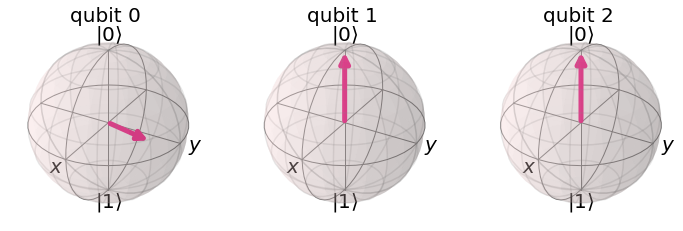

In [63]:
# First, let's initialize Alice's q0
qc.append(initial_gate, aliceq)
plot_bloch_multivector(qc)

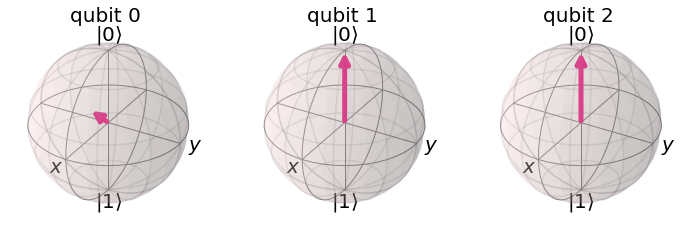

In [64]:
qc.append(encrypt(otp_key), aliceq)
qc.barrier()
plot_bloch_multivector(qc)

In [65]:
# Now begins the teleportation protocol
create_bell_pair(qc, sharedq, bobq)
qc.barrier()

# Send q1 to Alice and q2 to Bob
alice_gates(qc, aliceq, sharedq)
qc.barrier()

# Bob decodes qubits
bob_gates(qc, aliceq, sharedq, bobq)
qc.barrier()

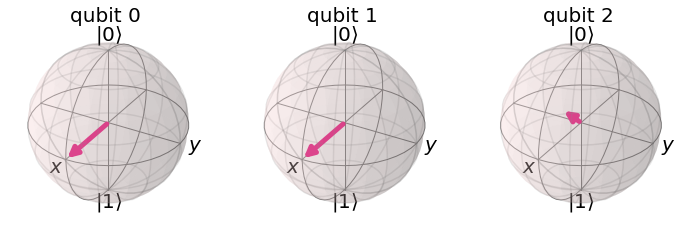

In [66]:
# Finally, lets reverse the qubit we got to see if its correct
plot_bloch_multivector(qc)

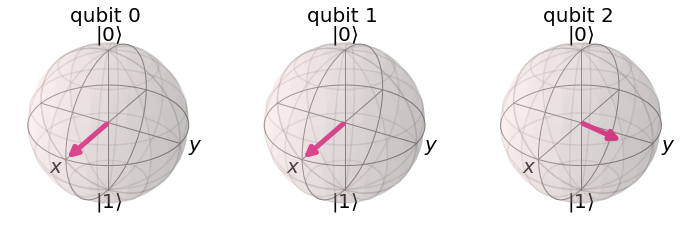

In [67]:
qc.append(decrypt(otp_key), bobq)
plot_bloch_multivector(qc)

In [68]:
qc.append(reversed_gate, bobq)
qc.measure(bobq, c)

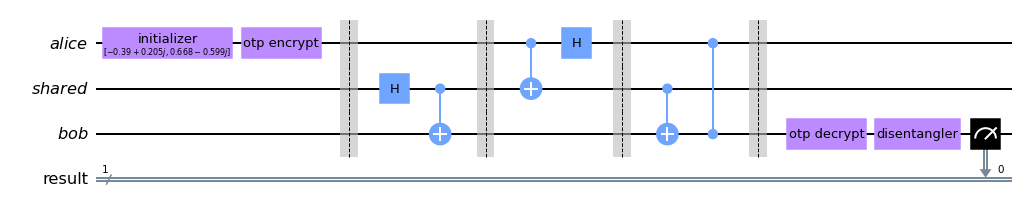

In [69]:
# Display the circuit
qc.draw()

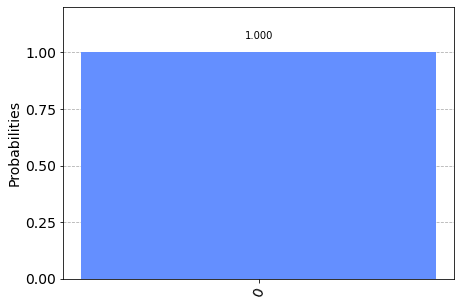

In [70]:
btype = "simulator"
backend = get_backend(btype)
results = get_results(backend, btype, qc)
plot_histogram(results)